# Forest observations with eo-learn and sentinelhub-py

In [1]:
from eolearn.core import EOPatch, FeatureType, EOTask
from eolearn.io import SentinelHubInputTask, SentinelHubEvalscriptTask
from eolearn.features import NormalizedDifferenceIndexTask
from eolearn.mask import CloudMaskTask

from sentinelhub import (
    BBox, CRS, Geometry, to_utm_bbox, bbox_to_dimensions,
    DataCollection, SentinelHubRequest
)

import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import datetime as dt
import pandas as pd

## Define AOI

EO-Browser polygon tool is rather useful to define AOI:

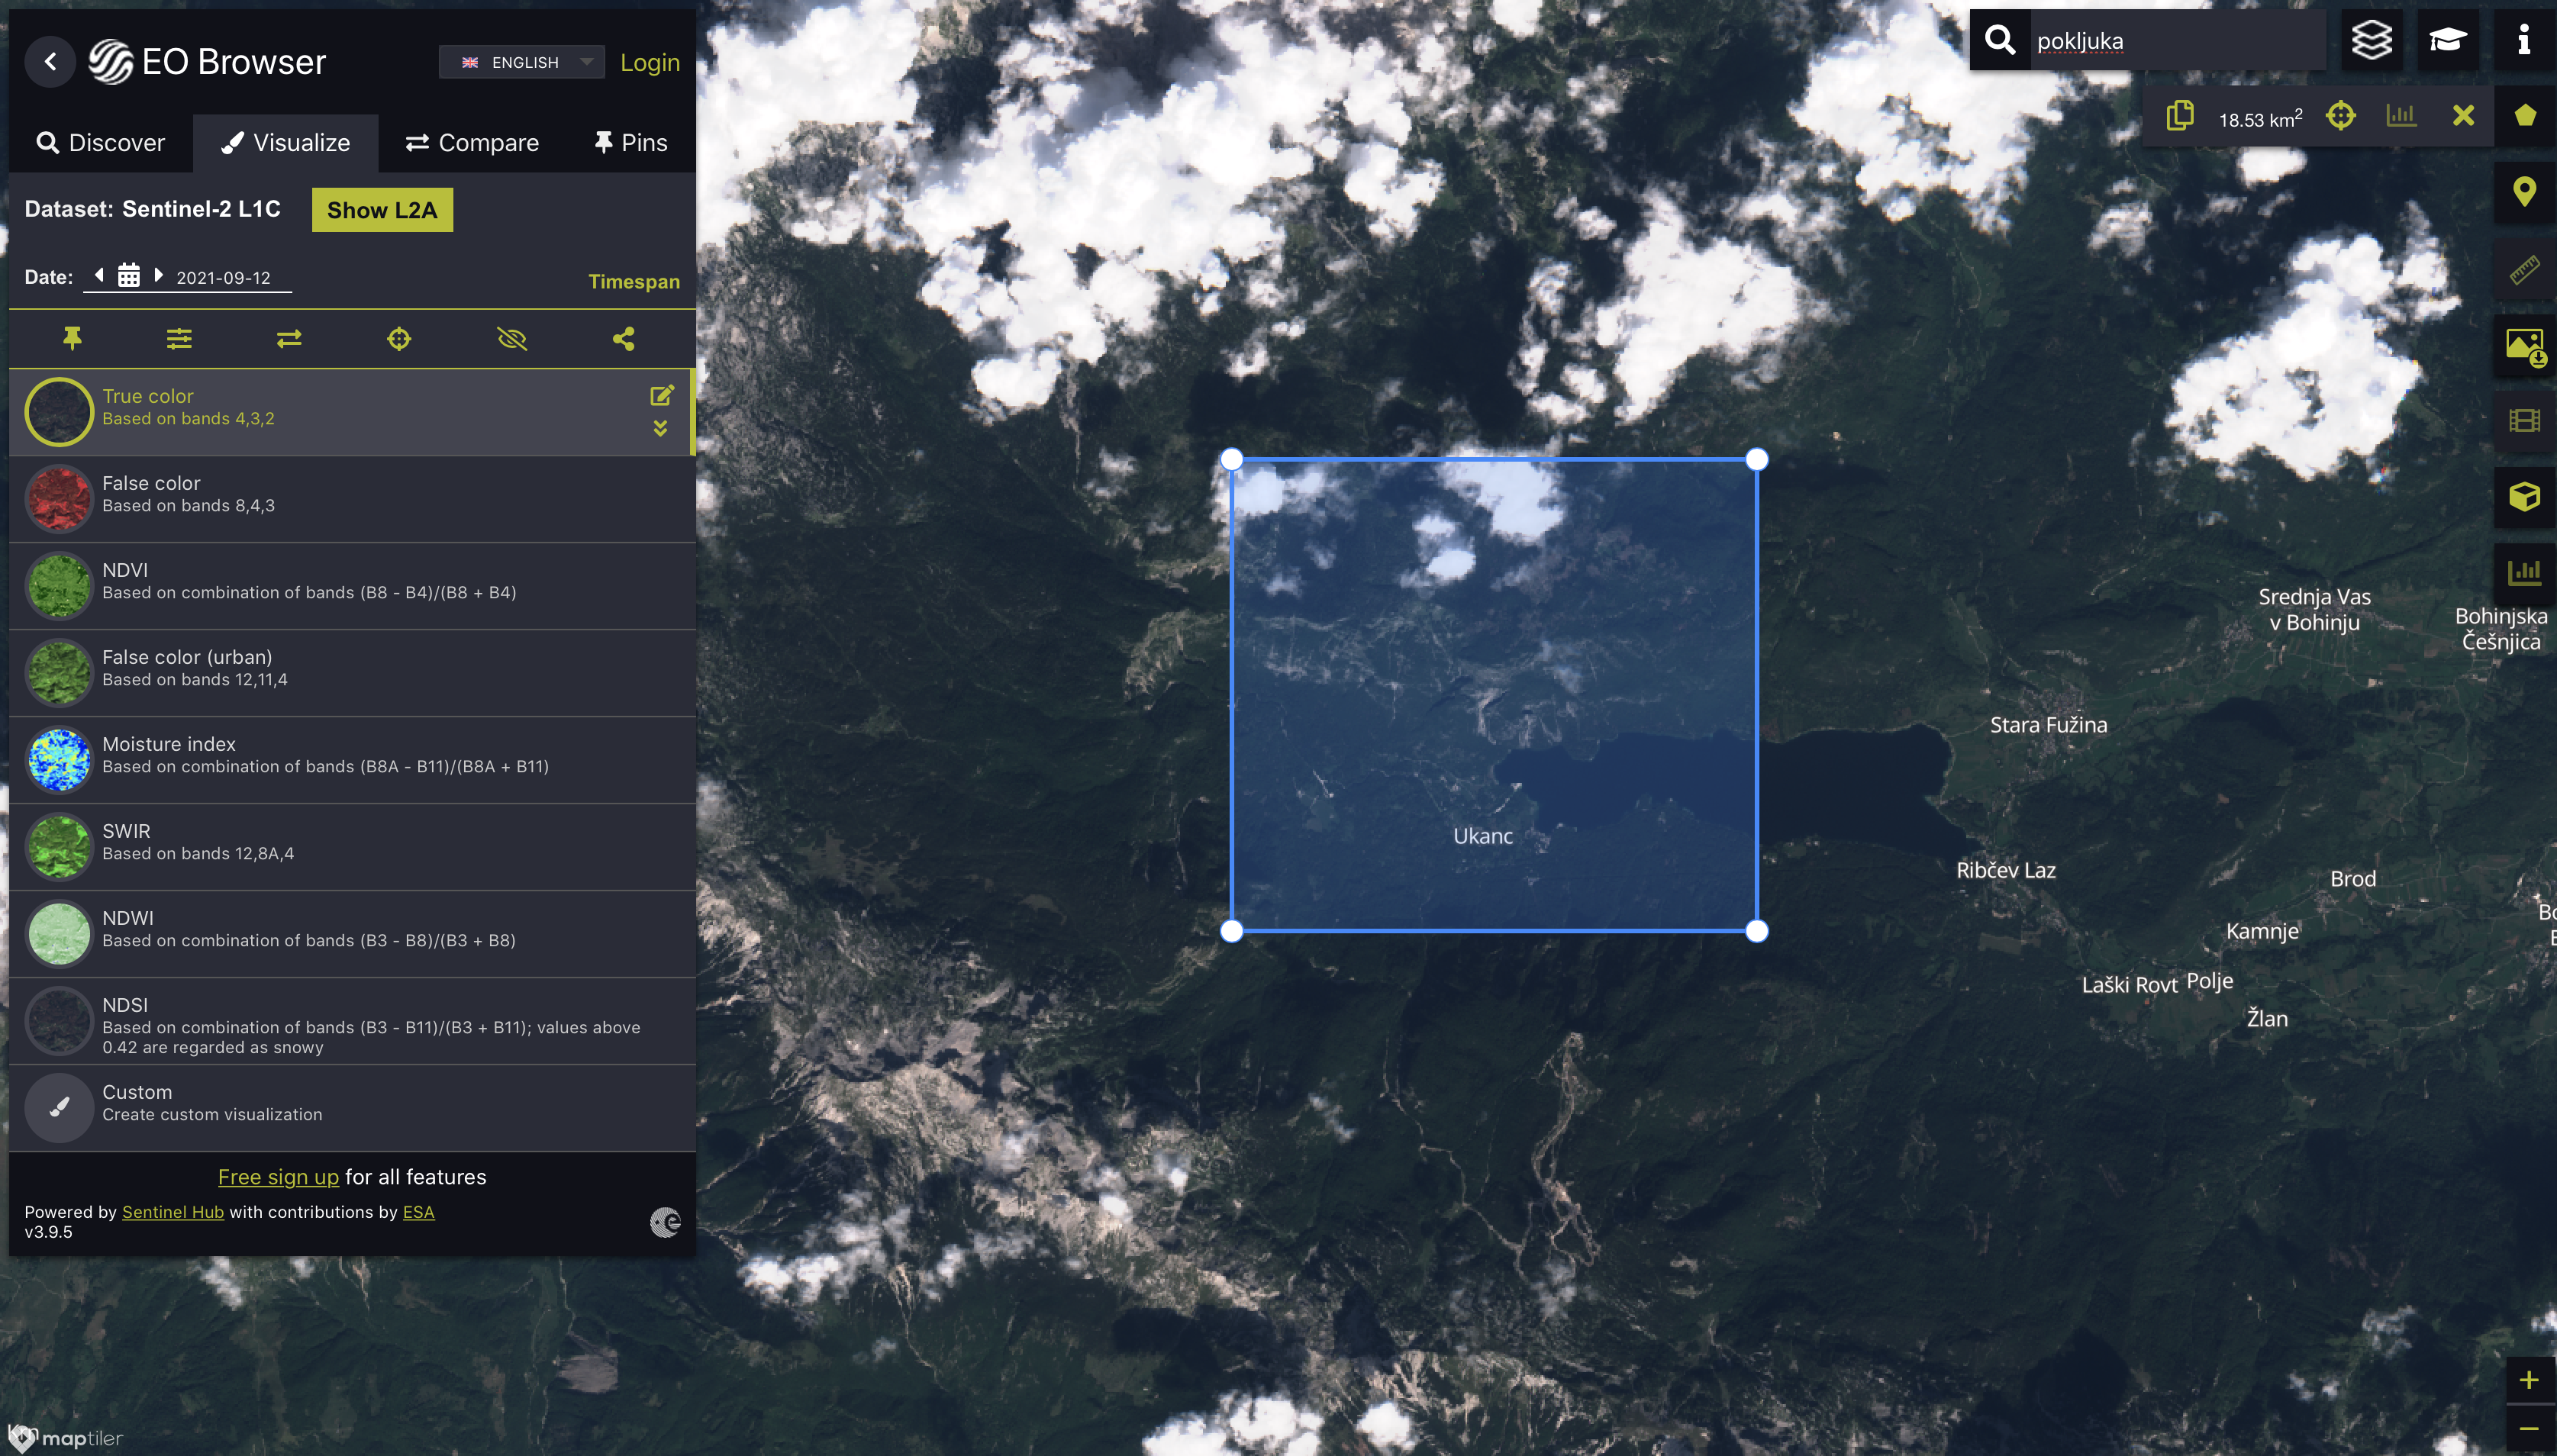

In [2]:
geometry = Geometry(
    geometry=json.loads('{"type":"Polygon","coordinates":[[[13.801661,46.271927],[13.801661,46.308581],[13.860712,46.308581],[13.860712,46.271927],[13.801661,46.271927]]]}'),
    crs=CRS.WGS84
)

bbox = to_utm_bbox(geometry.bbox)
s2_bbox = BBox(bbox=np.round(list(bbox),-1).tolist(), crs=bbox.crs)

In [3]:
bbox, s2_bbox

(BBox(((407665.73106383963, 5124958.977040688), (412274.2409680468, 5128964.578411702)), crs=CRS('32633')),
 BBox(((407670.0, 5124960.0), (412270.0, 5128960.0)), crs=CRS('32633')))

## Download Copernicus services' Corine Land Cover data

[Corine Land Cover](https://collections.sentinel-hub.com/corine-land-cover/) data collection on SH

In [4]:
corine_collection = DataCollection.define_byoc(
        'cbdba844-f86d-41dc-95ad-b3f7f12535e9',
        service_url='https://creodias.sentinel-hub.com'
)

Mapping of CORINE Land Cover to forest types

```
CLC === 23 - Broad-leaved forest
CLC === 24 - Coniferous forest
CLC === 25 - Mixed forest
```

In [5]:
corine_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC"],
    output: { 
      id: 'CORINE_LC',
      bands: 1, 
      sampleType: SampleType.UINT16
    }
  }
}
function evaluatePixel(sample) {
   return {'CORINE_LC': [sample.CLC]}
}
"""

In [6]:
corinelc_bounds = [0, 22.5, 23., 24.5, 25.5, 1000]
corinelc_cmap = ListedColormap(['#fff', '#80ff00', '#00a600', '#4dff00', '#fff'], name="corinelc_cmap")
corinelc_norm = BoundaryNorm(corinelc_bounds, corinelc_cmap.N)

In [30]:
corine_task = SentinelHubEvalscriptTask(
    features = [(FeatureType.MASK_TIMELESS, 'CORINE_LC')],
    evalscript = corine_evalscript,
    data_collection = corine_collection,
    resolution=(20, 20),
    mosaicking_order='mostRecent'
)

In [31]:
%%time
eopatch = corine_task.execute(bbox=s2_bbox)

CPU times: user 16.6 ms, sys: 24 ms, total: 40.6 ms
Wall time: 434 ms


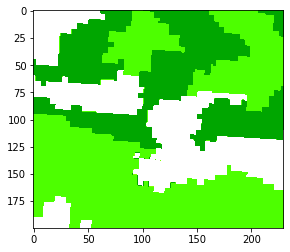

In [32]:
plt.imshow(eopatch.mask_timeless['CORINE_LC'][...,0], cmap=corinelc_cmap, norm=corinelc_norm)

## Download S-2 data

In [33]:
s2_data_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=DataCollection.SENTINEL2_L1C.bands,
    bands_feature=(FeatureType.DATA, 'S2'),
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM')],
    resolution=(20, 20),
    time_difference=dt.timedelta(hours=2),
    maxcc=0.5
)

In [34]:
%%time
eopatch = s2_data_task.execute(eopatch=eopatch, bbox=s2_bbox, time_interval=('2020-01-01','2020-12-31'))

CPU times: user 3.23 s, sys: 1.04 s, total: 4.27 s
Wall time: 7.38 s


In [35]:
len(eopatch.timestamp)

80

## Load the data from stored eo-patch

In [37]:
eopatch = EOPatch.load('../data/forest_eopatch/')

In [38]:
eopatch

EOPatch(
  data: {
    S2: numpy.ndarray(shape=(80, 200, 230, 13), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(80, 200, 230, 1), dtype=uint8)
    dataMask: numpy.ndarray(shape=(80, 200, 230, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    CORINE_LC: numpy.ndarray(shape=(200, 230, 1), dtype=uint16)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.5
    size_x: 230
    size_y: 200
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 23, 59, 59))
  }
  bbox: BBox(((407670.0, 5124960.0), (412270.0, 5128960.0)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2020, 1, 1, 10, 7, 47), ..., datetime.datetime(2020, 12, 26, 10, 7, 49)], length=80
)

## Let's have a look at data

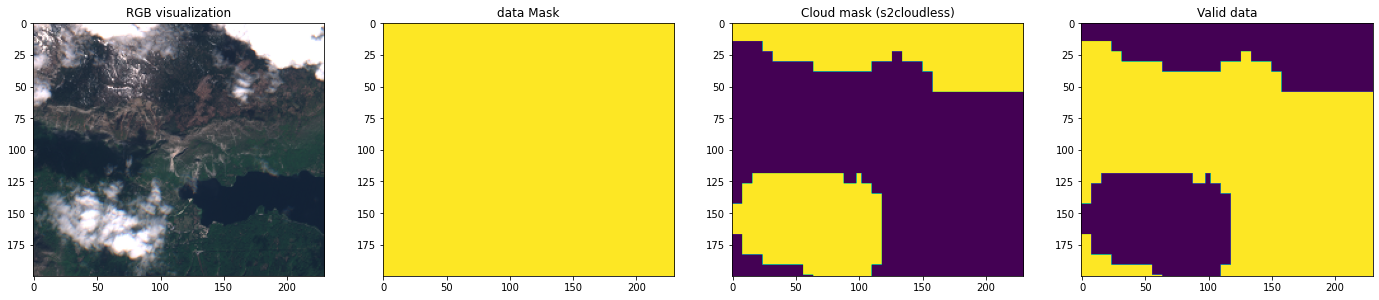

In [39]:
time_idx = 29
fig, ax = plt.subplots(ncols=4, figsize=(24,6))
ax[0].imshow(np.clip(eopatch.data['S2'][time_idx][..., [3,2,1]] * 2.5, 0, 1))
ax[0].set_title('RGB visualization');

ax[1].imshow(eopatch.mask['dataMask'][time_idx][..., 0], vmin=0, vmax=1)
ax[1].set_title('data Mask');

ax[2].imshow(eopatch.mask['CLM'][time_idx][..., 0], vmin=0, vmax=1)
ax[2].set_title('Cloud mask (s2cloudless)');

ax[3].imshow((eopatch.mask['dataMask'][time_idx][..., 0] & ~eopatch.mask['CLM'][time_idx][..., 0]), vmin=0, vmax=1)
ax[3].set_title('Valid data');

## Calculate NDVI task

In [40]:
ndvi_task = NormalizedDifferenceIndexTask(
    input_feature=(FeatureType.DATA, 'S2'),
    output_feature=(FeatureType.DATA, 'NDVI'), 
    bands=[DataCollection.SENTINEL2_L1C.bands.index('B08'), DataCollection.SENTINEL2_L1C.bands.index('B04')]
)

In [41]:
%%time
eopatch = ndvi_task.execute(eopatch=eopatch)

CPU times: user 33.7 ms, sys: 1.24 ms, total: 35 ms
Wall time: 33.6 ms


## (Re)calculating cloud mask

In [42]:
add_clm = CloudMaskTask(
    data_feature='S2',
    all_bands=True,
    processing_resolution='20m',
    mono_features=('CLP_local', 'CLM_local'),
    is_data_feature='dataMask',
    mask_feature=None,
    mono_threshold=0.4,
    average_over=8,
    dilation_size=4)

In [43]:
%%time
eopatch = add_clm.execute(eopatch=eopatch)

CPU times: user 3min 31s, sys: 403 ms, total: 3min 32s
Wall time: 14.3 s


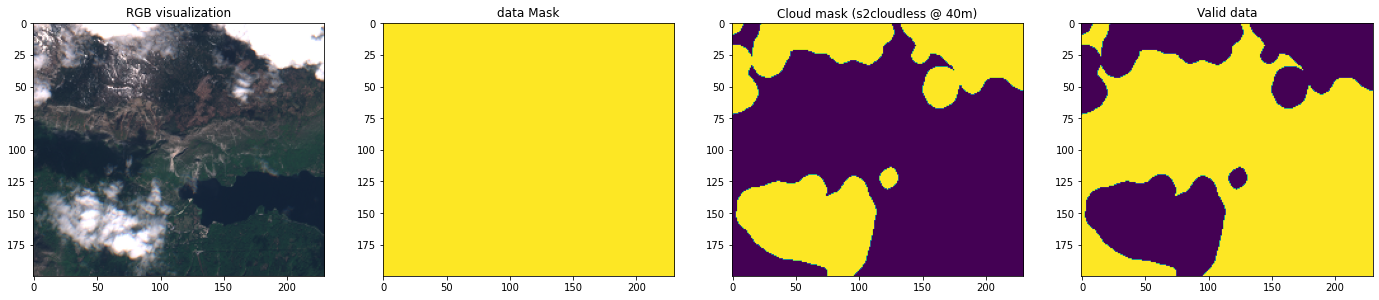

In [44]:
time_idx = 29
fig, ax = plt.subplots(ncols=4, figsize=(24,6))
ax[0].imshow(np.clip(eopatch.data['S2'][time_idx][..., [3,2,1]] * 2.5, 0, 1))
ax[0].set_title('RGB visualization');

ax[1].imshow(eopatch.mask['dataMask'][time_idx][..., 0], vmin=0, vmax=1)
ax[1].set_title('data Mask');

ax[2].imshow(eopatch.mask['CLM_local'][time_idx][..., 0], vmin=0, vmax=1)
ax[2].set_title('Cloud mask (s2cloudless @ 40m)');

ax[3].imshow((eopatch.mask['dataMask'][time_idx][..., 0] & ~eopatch.mask['CLM_local'][time_idx][..., 0]), vmin=0, vmax=1)
ax[3].set_title('Valid data');

## Plot NDVI through the year for particular Corine LC types

### Mask out missing data and clouds

In [45]:
ndvi = eopatch.data['NDVI']

In [46]:
corine_mask = np.repeat(np.array(eopatch.mask_timeless['CORINE_LC'])[np.newaxis,:], len(eopatch.timestamp), axis=0)

In [47]:
stats_clc = {}
for name, clc_code in zip(['broadleaved','coniferous','mixed'], [23,24,25]):
    data = np.ma.array(ndvi, mask=~(eopatch.mask['dataMask'] & ~eopatch.mask['CLM_local'] & (corine_mask==clc_code)), fill_value=np.NaN)
    stats_clc[name] = {
        'mean': np.nanmean(data.squeeze(), axis=(1,2)),
        'std': np.nanstd(data.squeeze(), axis=(1,2))
    }

### Create a pandas dataframe with mean and standard deviation for each S2 observation

In [48]:
df = pd.concat(
    [
        pd.DataFrame(data={
            'forest_type': len(eopatch.timestamp)*[name],
            'mean': stats_clc[name]['mean'],
            'std': stats_clc[name]['std'],
            'timestamp': eopatch.timestamp
        }) for name in stats_clc
    ]
)

In [49]:
df.head()

forest_type      mean       std           timestamp
0  broadleaved  0.334830  0.139157 2020-01-01 10:07:47
1  broadleaved  0.364771  0.114689 2020-01-06 10:07:46
2  broadleaved  0.368646  0.092954 2020-01-11 10:07:46
3  broadleaved  0.341622  0.073119 2020-01-14 10:17:42
4  broadleaved  0.115671  0.029358 2020-01-19 10:17:41

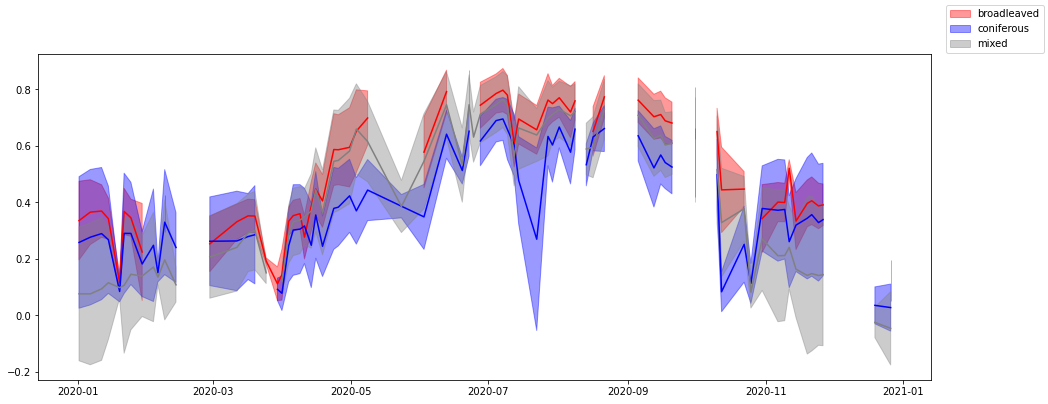

In [50]:
fig, ax = plt.subplots(figsize=(16,6))
for forest_type, col in zip(['broadleaved','coniferous','mixed'], ['red', 'blue', 'gray']):
    ax.plot(df.timestamp.unique(), df[df.forest_type==forest_type]['mean'].values, color=col)
    ax.fill_between(df.timestamp.unique(), 
                    df[df.forest_type==forest_type]['mean'].values-df[df.forest_type==forest_type]['std'].values,
                    df[df.forest_type==forest_type]['mean'].values+df[df.forest_type==forest_type]['std'].values, 
                    label=forest_type, color=col, alpha=0.4
                   )
fig.legend();